## AI Trends Searcher using CrewAI RAG

Using Crew AI to create sophisticated AI news search and writer agents. Using CrewAI RAG create AI Assistants to Run News Agency for AI trends with summarized reports.

This innovative approach combines Retrieving and Generating information, revolutionising how we search for AI news articles, analyse them, and deliver in-depth reports.

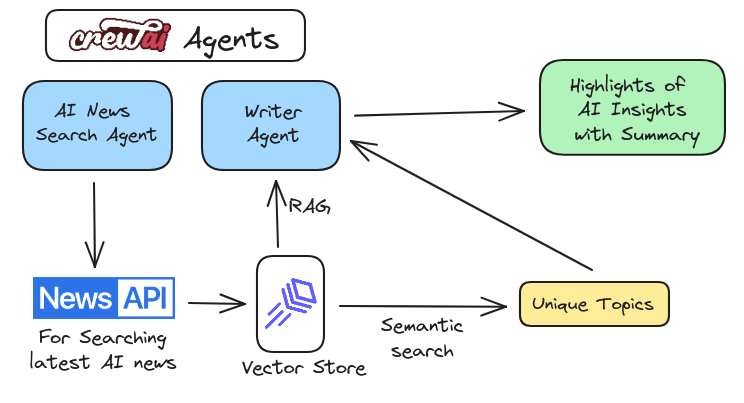

Get Free News API Key at [link](https://newsapi.org/)

### Install required packages


In [1]:
!pip install crewai langchain-community langchain-openai langchain-google-genai requests duckduckgo-search lancedb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Importing modules

In [2]:
from crewai import Agent, Task, Crew, Process
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.retrievers import BaseRetriever
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import LlamafileEmbeddings
from langchain.tools import tool
from langchain_community.document_loaders import WebBaseLoader
import requests, os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import LanceDB
from langchain_community.tools import DuckDuckGoSearchRun

### Set API keys as environment variable

In [ ]:
os.environ["NEWSAPI_KEY"] = "...."

### Using OpenAI embedding function and LLM

In [ ]:
# @title LLM Config

LLM = "OPENAI_GPT4"  # @param ["OPENAI_GPT4", "GEMINI_PRO"]
API_KEY = "sk-proj-..."  # @param {type:"string"}

In [14]:
if LLM == "OPENAI_GPT4":
    os.environ["OPENAI_API_KEY"] = API_KEY
    embedding_function = OpenAIEmbeddings()
    llm = ChatOpenAI(model="gpt-4o")
elif LLM == "GEMINI_PRO":
    os.environ["GOOGLE_API_KEY"] = API_KEY
    embeddding_function = LlamafileEmbeddings()
    llm = ChatGoogleGenerativeAI(model="gemini-pro")

### Set up the LanceDB vectorDB

In [15]:
import lancedb


# creating lancedb table with dummy data
def lanceDBConnection(dataset):
    db = lancedb.connect("/tmp/lancedb")
    table = db.create_table("tb", data=dataset, mode="overwrite")
    return table


embedding = OpenAIEmbeddings()
emb = embedding.embed_query("hello_world")
dataset = [{"vector": emb, "text": "dummy_text"}]

# LanceDB as vector store
table = lanceDBConnection(dataset)

### Save latest AI News in vectorDB

In [54]:
from crewai_tools import BaseTool


class SearchNewsDB(BaseTool):
    def __init__(self):
        super().__init__(
            name="News DB Tool",
            description="Fetch and process news articles from various sources",
        )

    def _run(self, query: str):
        """Fetch news articles and process their contents."""
        API_KEY = os.getenv("NEWSAPI_KEY")  # Fetch API key from environment variable
        base_url = "https://newsapi.org/v2/top-headlines?sources=techcrunch"
        params = {
            "sortBy": "publishedAt",
            "apiKey": API_KEY,
            "language": "en",
            "pageSize": 15,
        }

        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            return "Failed to retrieve news."

        articles = response.json().get("articles", [])
        all_splits = []

        for article in articles:
            try:
                # Assuming WebBaseLoader can handle a list of URLs
                loader = WebBaseLoader(article["url"])
                docs = loader.load()
                text_splitter = RecursiveCharacterTextSplitter(
                    chunk_size=1000, chunk_overlap=200
                )
                splits = text_splitter.split_documents(docs)
                all_splits.extend(splits)  # Accumulate splits from all articles
            except Exception as e:
                print(f"Error processing article {article['url']}: {e}")

        # Index the accumulated content splits if there are any
        if all_splits:
            try:
                vectorstore = LanceDB.from_documents(
                    all_splits, embedding=embedding_function
                )
                retriever = vectorstore.similarity_search(query)
                return retriever
            except Exception as e:
                return f"Error indexing documents: {e}"
        else:
            return "No content available for processing."

### Building RAG to get news from vectorDB

In [63]:
class GetNews(BaseTool):
    def __init__(self):
        super().__init__(
            name="Get News Tool",
            description="Search LanceDB for relevant news information based on a query",
        )

    def _run(self, query: str) -> str:
        """Search LanceDB for relevant news information based on a query."""
        try:
            vectorstore = LanceDB(embedding=embedding_function)
            retriever = vectorstore.similarity_search(query)
            return retriever
        except Exception as e:
            return f"Error retrieving news: {e}"

### Setup search tool for News articles on the web

In [56]:
# Make sure to Install duckduckgo-search for this example
!pip install -U duckduckgo_search

from duckduckgo_search import DDGS

search_tool = DDGS()

### Setting up Agents

In [64]:
# Defining Search and Writer agents with roles and goals
news_search_agent = Agent(
    role="AI News Searcher",
    goal="Generate key points for each news article from the latest news",
    backstory="""You work at a leading tech think tank.
    Your expertise lies in identifying emerging trends in the field of AI.
    You have a knack for dissecting complex data and presenting
    actionable insights.""",
    tools=[SearchNewsDB()],  # Note the instantiation here
    allow_delegation=True,
    verbose=True,
)

# Agent configuration
writer_agent = Agent(
    role="Writer",
    goal="Identify all the topics received. Use the GetNews tool to verify each topic. Use the search tool for detailed exploration of each topic. Summarise the retrieved information in depth for every topic.",
    backstory="""You are a renowned Content Strategist, known for
    your insightful and engaging articles.
    You transform complex concepts into compelling narratives.""",
    tools=[GetNews()],  # Instantiate GetNews directly
    allow_delegation=True,
    verbose=True,
)

### Tasks to perform

In [65]:
from crewai import Task

# Creating search and writer tasks for agents
news_search_task = Task(
    description="""Conduct a comprehensive analysis of the latest advancements in AI in 2024.
    Identify key trends, breakthrough technologies, and potential industry impacts.
    Your final answer MUST be a full analysis report""",
    expected_output="Create key points list for each news",
    agent=news_search_agent,
    tools=[SearchNewsDB()],  # Pass the tool instance, not the _run method
)

writer_task = Task(
    description="""Using the insights provided, summarize each post and
    highlight the most significant AI advancements.
    Your post should be informative yet accessible, catering to a tech-savvy audience.
    Make it sound cool, avoid complex words so it doesn't sound like AI.
    Your final answer MUST not be more than 50 words.""",
    expected_output="Write a short summary under 50 words for each news Headline separately",
    agent=writer_agent,
    context=[news_search_task],
    tools=[GetNews()],  # Pass the tool instance, not the _run method
)

### Create a Crew

In [66]:
# Instantiate Crew with Agents and their tasks
news_crew = Crew(
    agents=[news_search_agent, writer_agent],
    tasks=[news_search_task, writer_task],
    process=Process.sequential,
    manager_llm=llm,
)

In [67]:
news_crew

Crew(id=d9e467a2-39d5-4ab8-aa97-e2c0929c1a85, process=sequential, number_of_agents=2, number_of_tasks=2)

### Kickoff the crew - let the magic happen

In [68]:
# Execute the crew to see RAG in action
result = news_crew.kickoff()

# Agent: AI News Searcher
## Task: Conduct a comprehensive analysis of the latest advancements in AI in 2024.
    Identify key trends, breakthrough technologies, and potential industry impacts.
    Your final answer MUST be a full analysis report
 

I encountered an error while trying to use the tool. This was the error: 1 validation error for SearchNewsDBSchema
query
  Input should be a valid string [type=string_type, input_value={'description': 'latest a...AI 2024', 'type': 'str'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/string_type.
 Tool News DB Tool accepts these inputs: Tool Name: News DB Tool
Tool Arguments: {'query': {'description': None, 'type': 'str'}}
Tool Description: Fetch and process news articles from various sources



# Agent: AI News Searcher
## Thought: I need to gather data on the latest advancements in AI for 2024. This will involve searching for relevant news articles to identify key trends, breakthrough technologies, a

In [69]:
print(result)

1. Altera raised $9 million to develop emotionally intelligent AI agents for gaming, aiming to create more human-like interactions in games, particularly Minecraft, enhancing player experiences.  
2. Google’s AlphaFold is advancing protein structure predictions, enabling researchers to better understand biological processes for breakthroughs in biotechnology and medicine.  
3. The emergence of socially aware AI in gaming opens up new ways for players to interact, enhancing emotional connections and experiences.  
4. The democratization of AI in biotech signals a shift towards making advanced tools widely accessible for researchers, driving innovation across the field.  
5. These trends indicate that AI is deeply integrating into various industries, enhancing engagement and productivity in everyday life.
